**Machine Learning for Cancer Prediction**

This collection of data is part of the RNA-Seq (HiSeq) PANCAN data set, it is a random extraction of gene expressions of patients having different types of tumor: BRCA, KIRC, COAD, LUAD and PRAD.

BRCA-Beast invasive carcinoma


COAD-Colon adenocarcinoma


KIRC-kidney renal clear cell carcinoma


LUAD-lung adenocarcinoma


PRAD-prostrate adenocarcinoma


Samples (instances) are stored row-wise. Variables (attributes) of each sample are RNA-Seq gene expression levels measured by illumina HiSeq platform.

The data is available here on the link : https://archive.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq

In [66]:
#data handling & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [67]:
#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler

In [68]:
#feature selection
from sklearn.feature_selection import mutual_info_classif

#Classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



In [98]:
#performance Metrics
from sklearn.metrics import balanced_accuracy_score,f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,auc
from sklearn.metrics import roc_curve


Import the data.

*   i have uploaded the data on the google drive

data consists of two files
a) the data file
b) label file


In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
lpath = '/content/drive/MyDrive/cancerdataset/labels.csv'
dpath = '/content/drive/MyDrive/cancerdataset/data.csv'
label = pd.read_csv(lpath)
data = pd.read_csv(dpath)

In [72]:
label.shape


(801, 2)

In [74]:
label.head(10)

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA
5,sample_5,PRAD
6,sample_6,KIRC
7,sample_7,PRAD
8,sample_8,BRCA
9,sample_9,PRAD


In [75]:
print(data.shape)
data.head()

(801, 20532)


,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [76]:
data.columns[0:2]

Index(['Unnamed: 0', 'gene_0'], dtype='object')

In [77]:
datanull = data.isnull().sum()
labelnull = label.isnull().sum()
g = [i for i in datanull if i > 0]

print('columns with missing values :%d'%len(g))

h = [i for i in labelnull if i > 0]
print('columns with missing values :%d'%len(h))

columns with missing values :0
columns with missing values :0


In [78]:
#count the number of tumors occuring through label data
print(label['Class'].value_counts())

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64


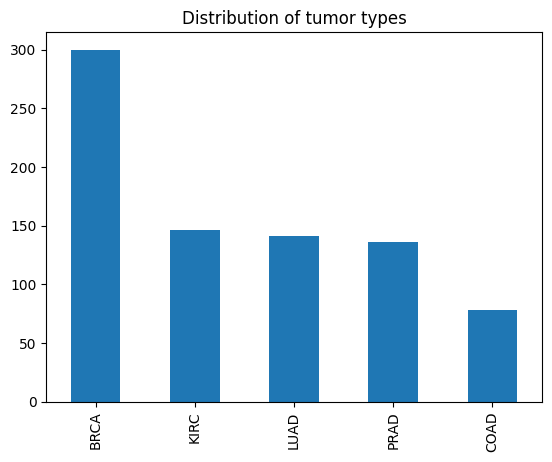

In [79]:
#distribution of tumor type
label['Class'].value_counts().plot(kind='bar')
plt.title('Distribution of tumor types')
plt.show()

Data Preprocessing

In [80]:
X = data.iloc[:,1:]
Y = label['Class']

Encode the Labels for the classification of the labels from 0 -5

In [81]:
labelencoder = LabelEncoder()
labelencoder.fit(Y)
Y_encoded = labelencoder.transform(Y)
lab = labelencoder.classes_
classes = np.unique(Y_encoded)


In [82]:
print(classes)

[0 1 2 3 4]


In [83]:
lab

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

Split for training and test the data


80% for training

20% for testing

In [84]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y_encoded,test_size=0.2,random_state=0)

Normalizing the data to improve performance and remove any bias from the data

In [85]:
#Normalize - scale b/w 0 - 1
scaler = MinMaxScaler()
X_trainnorm = scaler.fit_transform(X_train)
X_testnorm = scaler.transform(X_test)

We can only show certain features which are relevant for the classification.

We use Mutual information algorithm to compute the relevance of each feature. The Top n features will be selected for ML analysis

In [86]:
MI = mutual_info_classif(X_trainnorm,Y_train)

In [87]:
MI.shape

(20531,)

In [88]:
#select the top n features .
n = 2000
top_n_features = np.argsort(MI)[::-1][-n:]
print(top_n_features)
print(len(top_n_features))

[14725  9558  9990 ... 11926 11934     0]
2000


In [90]:
X_trainselected = X_trainnorm[:,top_n_features]
X_testselected = X_testnorm[:,top_n_features]

In [91]:
X_trainselected.shape

(640, 2000)

**Classification** - Random Forest Classifier

In [92]:
#random forest
#multiclass - one vs rest strategy

RF = OneVsRestClassifier(RandomForestClassifier(max_features=0.2,random_state=0))
RF.fit(X_trainselected,Y_train)
y_pred = RF.predict(X_testselected)
pred_prob = RF.predict_proba(X_testselected)

In [93]:
#model evaluation via metrics - accuracy score, precision , recall, f1 score, confusion metrix, roc curve

accuracy = np.round(balanced_accuracy_score(Y_test,y_pred),4)

print('Accuracy : %.4f'%accuracy)

precision = np.round(precision_score(Y_test,y_pred,average='weighted'),4)

print('Precision : %.4f'%precision)

recall = np.round(recall_score(Y_test,y_pred,average='weighted'),4)

print('Recall : %.4f'%recall)

f1score = np.round(f1_score(Y_test,y_pred,average='weighted'),4)

print('F1 Score : %.4f'%f1score)

report = classification_report(Y_test,y_pred,target_names=lab)

print('Classification Report : \n',report)

cm = confusion_matrix(Y_test,y_pred)

print('Confusion Matrix : \n',cm)


Accuracy : 0.9070
Precision : 0.9314
Recall : 0.9255
F1 Score : 0.9237
Classification Report : 
               precision    recall  f1-score   support

        BRCA       0.88      1.00      0.94        67
        COAD       0.87      0.93      0.90        14
        KIRC       1.00      1.00      1.00        25
        LUAD       0.96      0.77      0.85        30
        PRAD       1.00      0.84      0.91        25

    accuracy                           0.93       161
   macro avg       0.94      0.91      0.92       161
weighted avg       0.93      0.93      0.92       161

Confusion Matrix : 
 [[67  0  0  0  0]
 [ 0 13  0  1  0]
 [ 0  0 25  0  0]
 [ 5  2  0 23  0]
 [ 4  0  0  0 21]]


In [94]:
rfcmdf = pd.DataFrame(cm,columns=lab,index=lab)
rfcmdf

,BRCA,COAD,KIRC,LUAD,PRAD
BRCA,67,0,0,0,0
COAD,0,13,0,1,0
KIRC,0,0,25,0,0
LUAD,5,2,0,23,0
PRAD,4,0,0,0,21


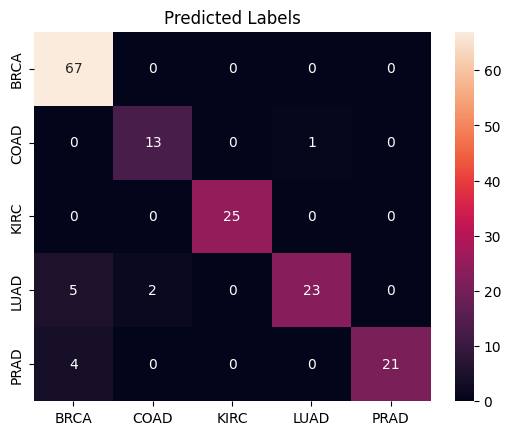

In [95]:
#visualize the heatmap
sns.heatmap(rfcmdf,annot=True,fmt='d')
plt.title('Predicted Labels')
plt.show()

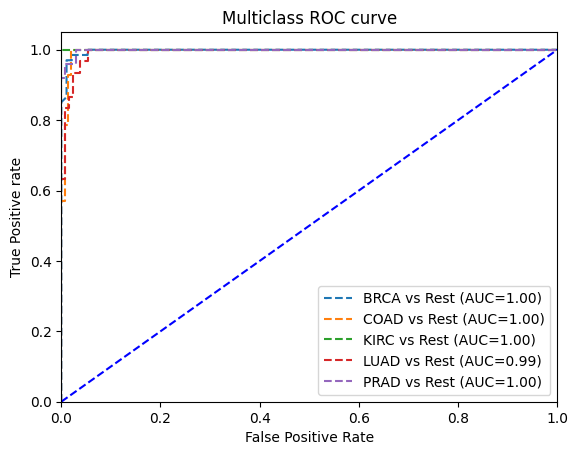

In [99]:
#roc curve
y_test_binarized=label_binarize(Y_test,classes=classes)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(lab[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

**Logistic Regression Classification**

In [100]:
#logistic Regression on the data

X_trainlr = X_trainnorm[:,top_n_features]
X_testlr = X_testnorm[:,top_n_features]

In [101]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_trainlr, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [103]:
predictions = logisticRegr.predict(X_testlr)

In [104]:
lrscore = logisticRegr.score(X_testlr, Y_test)
print(lrscore)

0.9937888198757764


In [106]:
lrcm = confusion_matrix(Y_test, predictions)
print(lrcm)

[[67  0  0  0  0]
 [ 0 14  0  0  0]
 [ 0  0 25  0  0]
 [ 0  0  0 30  0]
 [ 1  0  0  0 24]]


In [109]:
lrcmdf = pd.DataFrame(lrcm,columns=lab,index=lab)
lrcmdf

,BRCA,COAD,KIRC,LUAD,PRAD
BRCA,67,0,0,0,0
COAD,0,14,0,0,0
KIRC,0,0,25,0,0
LUAD,0,0,0,30,0
PRAD,1,0,0,0,24


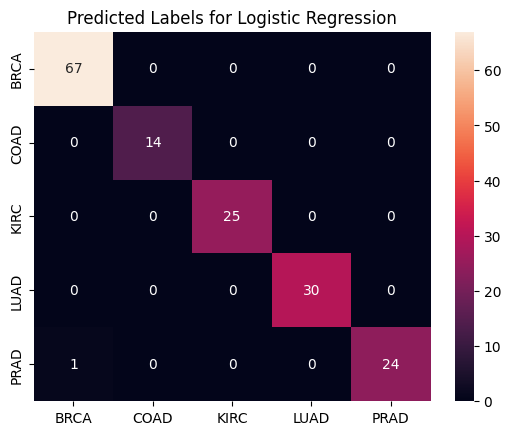

In [110]:
#visualize the heatmap
sns.heatmap(lrcmdf,annot=True,fmt='d')
plt.title('Predicted Labels for Logistic Regression')
plt.show()

In [111]:
#model evaluation via metrics - accuracy score, precision , recall, f1 score, confusion metrix, roc curve

accuracylr = np.round(balanced_accuracy_score(Y_test,predictions),4)

print('Accuracy : %.4f'%accuracylr)

precisionlr = np.round(precision_score(Y_test,predictions,average='weighted'),4)

print('Precision : %.4f'%precisionlr)

recalllr = np.round(recall_score(Y_test,predictions,average='weighted'),4)

print('Recall : %.4f'%recalllr)

f1scorelr = np.round(f1_score(Y_test,predictions,average='weighted'),4)

print('F1 Score : %.4f'%f1scorelr)

reportlr = classification_report(Y_test,predictions,target_names=lab)

print('Classification Report : \n',reportlr)

Accuracy : 0.9920
Precision : 0.9939
Recall : 0.9938
F1 Score : 0.9937
Classification Report : 
               precision    recall  f1-score   support

        BRCA       0.99      1.00      0.99        67
        COAD       1.00      1.00      1.00        14
        KIRC       1.00      1.00      1.00        25
        LUAD       1.00      1.00      1.00        30
        PRAD       1.00      0.96      0.98        25

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



**SVC Classifier**

In [117]:
X_trainsvc = X_trainnorm[:,top_n_features]
X_testsvc = X_testnorm[:,top_n_features]
rbf = SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_trainsvc, Y_train)
poly = SVC(kernel='poly', degree=2, C=1).fit(X_trainsvc, Y_train)

poly_pred = poly.predict(X_testsvc)
rbf_pred = rbf.predict(X_testsvc)

poly_accuracy = balanced_accuracy_score(Y_test, poly_pred)
poly_f1 = f1_score(Y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))


Accuracy (Polynomial Kernel):  99.20
F1 (Polynomial Kernel):  99.37


In [118]:
rbf_accuracy = balanced_accuracy_score(Y_test, rbf_pred)
rbf_f1 = f1_score(Y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))


Accuracy (RBF Kernel):  20.00
F1 (RBF Kernel):  24.46


In [119]:
#model evaluation via metrics - accuracy score, precision , recall, f1 score, confusion metrix, roc curve

accuracysvc = np.round(balanced_accuracy_score(Y_test,poly_pred),4)

print('Accuracy : %.4f'%accuracysvc)

precisionsvc = np.round(precision_score(Y_test,poly_pred,average='weighted'),4)

print('Precision : %.4f'%precisionsvc)

recallsvc = np.round(recall_score(Y_test,poly_pred,average='weighted'),4)

print('Recall : %.4f'%recallsvc)

f1scoresvc = np.round(f1_score(Y_test,poly_pred,average='weighted'),4)

print('F1 Score : %.4f'%recallsvc)

reportsvc = classification_report(Y_test,poly_pred,target_names=lab)

print('Classification Report : \n',reportsvc)

Accuracy : 0.9920
Precision : 0.9939
Recall : 0.9938
F1 Score : 0.9938
Classification Report : 
               precision    recall  f1-score   support

        BRCA       0.99      1.00      0.99        67
        COAD       1.00      1.00      1.00        14
        KIRC       1.00      1.00      1.00        25
        LUAD       1.00      1.00      1.00        30
        PRAD       1.00      0.96      0.98        25

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



In [120]:
svccm = confusion_matrix(Y_test, poly_pred)
print(svccm)

[[67  0  0  0  0]
 [ 0 14  0  0  0]
 [ 0  0 25  0  0]
 [ 0  0  0 30  0]
 [ 1  0  0  0 24]]


In [121]:
svccmdf = pd.DataFrame(svccm,columns=lab,index=lab)
svccmdf

,BRCA,COAD,KIRC,LUAD,PRAD
BRCA,67,0,0,0,0
COAD,0,14,0,0,0
KIRC,0,0,25,0,0
LUAD,0,0,0,30,0
PRAD,1,0,0,0,24


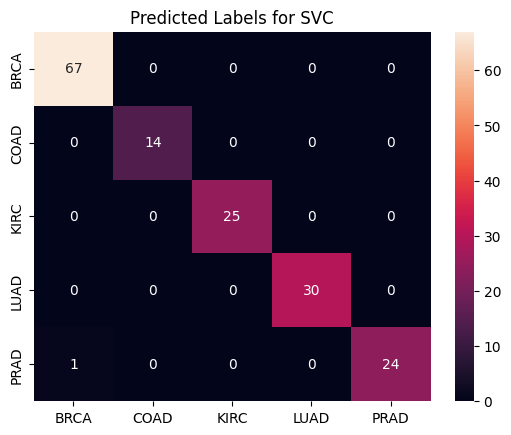

In [122]:
#visualize the heatmap
sns.heatmap(svccmdf,annot=True,fmt='d')
plt.title('Predicted Labels for SVC')
plt.show()